<h1><center>Physique numérique (PHY-3500) - Projet final</center></h1>
<hr>
<br><br>

**Membres de l'équipe**
| Nom | NI |
| --- | :---: |
| Maxime Tousignant-Tremblay | 536 772 369 |
| Philippe Morin | 536 776 382 |
| Emilie Carré Smith| 111 235 839 |


In [4]:
import numpy as np
import skimage as ski
import skimage.io
import skimage.color
import imageio.v3 as imageio
from numpy.typing import NDArray
from matplotlib import pyplot as plt
from skimage.metrics import structural_similarity as ssim


%matplotlib inline
%config InlineBackend.figure_formats = "svg",
plt.style.use("LabReport.mplstyle")

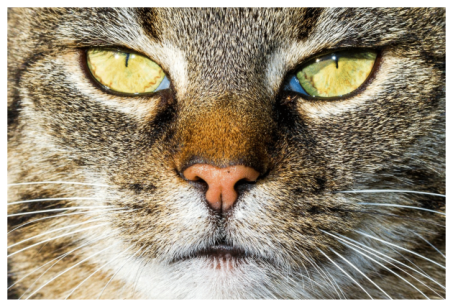

In [5]:
image = imageio.imread("cat.tiff")

plt.imshow(image)
plt.axis("off")
plt.show()

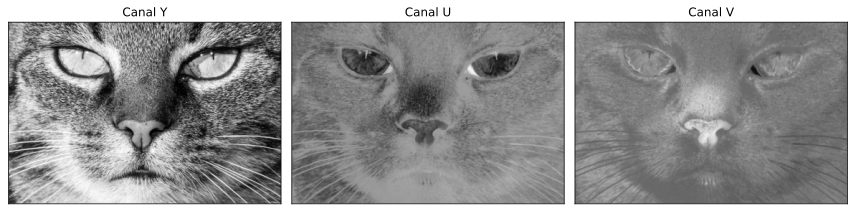

In [6]:
def rgb_to_yuv(rgb_image):
    """
    Convertit une image RGB en format YUV en utilisant une matrice de transformation fixe.

    Paramètres :
    rgb_image (numpy.ndarray) : L'image d'entrée au format RGB.

    Retour :
    numpy.ndarray : L'image convertie au format YUV.
    """
    transformation_matrix = np.array([
        [0.299, 0.587, 0.114],    # Coefficients pour Y
        [-0.14713, -0.28886, 0.436],  # Coefficients pour U
        [0.615, -0.51499, -0.10001]  # Coefficients pour V
    ])

    flat_rgb = rgb_image.reshape((-1, 3))
    yuv_image = flat_rgb @ transformation_matrix.T
    yuv_image = yuv_image.reshape(rgb_image.shape)
    return yuv_image

# Chargement de l'image
img_path = r'C:\Users\emili\Desktop\Projet\Physique-numerique\Projet\cat.tiff'
image = skimage.io.imread(img_path)

yuv_image = rgb_to_yuv(image)

fig, axes = plt.subplots(1, 3, figsize=(12, 8))
titles = ['Canal Y', 'Canal U', 'Canal V']
cmaps = ['gray', 'gray', 'gray']  


for i, ax in enumerate(axes):
    ax.set_title(titles[i])
    ax.imshow(yuv_image[:, :, i], cmap=cmaps[i])
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

Ratio de compression : 0.10
Réduction de mémoire : 90.00%


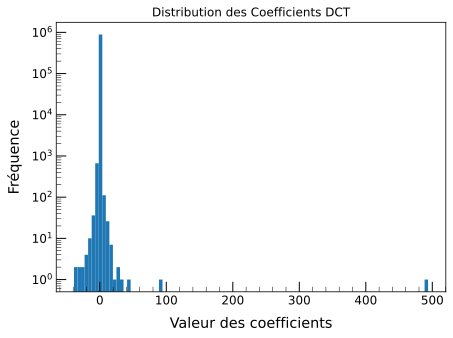

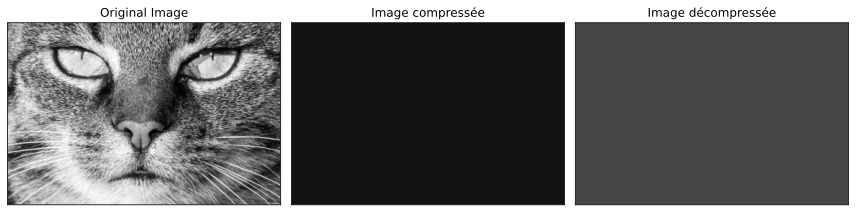

In [7]:
def init_dct_mat(N):
    """Crée une matrice de transformation DCT de taille N."""
    n = np.arange(N)
    k = np.arange(N).reshape(N, 1)
    facteur = np.pi * (2 * n + 1) / (2 * N)
    dct_mat = np.sqrt(2 / N) * np.cos(k * facteur)
    dct_mat[0] *= np.sqrt(0.5)
    return dct_mat


def compress_image(image_dct, ratio=0.1):
    """Compresse l'image en annulant les petits coefficients DCT."""
    # Calcul du seuil basé sur le quantile
    seuil = np.quantile(np.abs(image_dct), 1 - ratio)

    # Annulation des coefficients petits
    sig_coeffs = np.abs(image_dct) > seuil
    compr_img = image_dct * sig_coeffs
    compr_ratio = sig_coeffs.sum() / image_dct.size
    return compr_img, compr_ratio


# Charge une image et la convertit en niveaux de gris
img = ski.color.rgb2gray(ski.io.imread("cat.tiff"))
N, M = img.shape

# Création des matrices et application de la DCT
dct_mat_n = init_dct_mat(N)
dct_mat_m = init_dct_mat(M)
dct_img = dct_mat_n @ img @ dct_mat_m.T

# Compression de l'image et décompression via la DCT inverse
compr_img, compr_ratio = compress_image(dct_img, 0.1)
decompr_img = dct_mat_n.T @ img @ dct_mat_m

# Calcul de la réduction de mémoire
init_mem = img.size * img.itemsize
compr_mem = np.sum(compr_img != 0) * img.itemsize
mem_reduc = 100 * (1 - (compr_mem / init_mem))

# print(f"Image originale :\n {img}\n")
# print(f"Image après DCT et compression :\n {compr_img}\n")
# print(f"Image récupérée après décompression :\n {decompr_img}\n")
print(f"Ratio de compression : {compr_ratio:.2f}")
print(f"Réduction de mémoire : {mem_reduc:.2f}%")


plt.hist(dct_img.ravel(), bins=100, log=True)
plt.title("Distribution des Coefficients DCT")
plt.xlabel("Valeur des coefficients")
plt.ylabel("Fréquence")
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(12, 8))
axes[0].set_title("Original Image")
axes[0].imshow(img, cmap="gray")
axes[1].set_title("Image compressée")
axes[1].imshow(compr_img, cmap="gray")
axes[2].set_title("Image décompressée")
axes[2].imshow(decompr_img, cmap="gray")
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

Compression ratio: 0.10


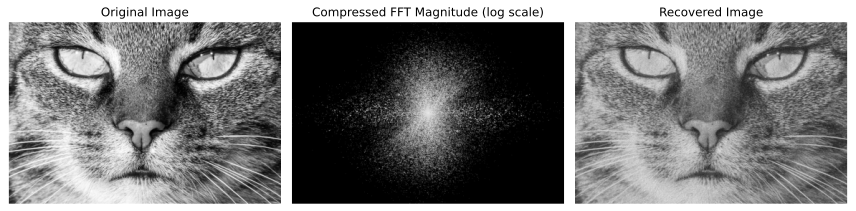

In [8]:
def compress_fft(img_fft, threshold_ratio=0.1):
    """Compresses the image by zeroing out small FFT coefficients."""
    mag = np.abs(img_fft)
    threshold = np.quantile(mag, 1 - threshold_ratio)
    sig = mag > threshold
    compr_fft = img_fft * sig
    compr_ratio = sig.sum() / img_fft.size
    return compr_fft, compr_ratio


# Read and convert an image to grayscale
img = ski.color.rgb2gray(ski.io.imread("cat.tiff"))
N, M = img.shape

# Apply FFT
fft_img = np.fft.fftshift(np.fft.fft2(img))

# Compress the image
compr_fft, compr_ratio = compress_fft(fft_img, threshold_ratio=0.1)
compr_fft_mag = np.log(np.abs(compr_fft) + 1e-10)

# Decompress the image
recovered_img = np.fft.ifft2(np.fft.ifftshift(compr_fft)).real
print(f"Compression ratio: {compr_ratio:.2f}")


# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(compr_fft_mag, cmap="gray")
plt.title("Compressed FFT Magnitude (log scale)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(recovered_img, cmap="gray")
plt.title("Recovered Image")
plt.axis("off")

plt.show()

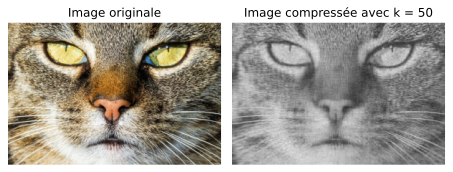

In [9]:
def svd_compress(image: NDArray, k: int) -> NDArray:
    """Compression d'image via SVD en gardant les k premières valeurs singulières.

    Paramètres
    ----------
        image
            Image en nuences de gris à compresser.
        k
            Nombre de valeurs singulières à garder.

    Retourne
    --------
        compr_image
            Approximation de l'image compressée.

    """
    # Algorithme SVD
    U, S, Vt = np.linalg.svd(image, full_matrices=False)

    # Matrices tronquées
    U_k = U[:, :k]
    S_k = np.diag(S[:k])
    Vt_k = Vt[:k, :]

    # Reconstruction
    # compr_image = np.dot(U_k, np.dot(S_k, Vt_k))
    compr_image = U_k @ (S_k @ Vt_k)
    return compr_image


# Lecture de l'image
image = ski.io.imread("cat.tiff")
gray_image = ski.color.rgb2gray(image)

k = 50  # Nombre de valeur singulière à garder
compr_img = svd_compress(gray_image, k)

plt.subplot(1, 2, 1)
plt.title("Image originale")
plt.imshow(image, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Image compressée avec k = " + str(k))
plt.imshow(compr_img, cmap="gray")
plt.axis("off")
plt.show()

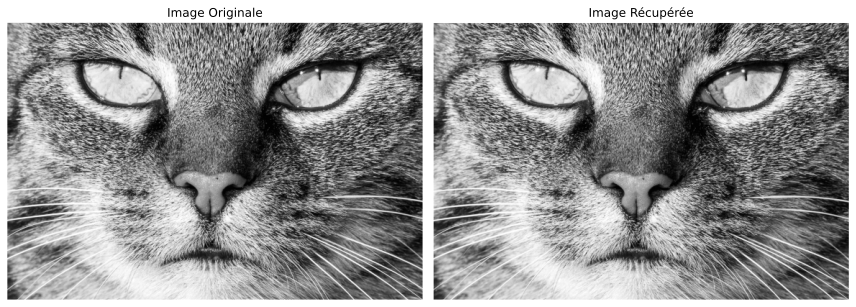

Rapport de compression : 0.50
PSNR : inf dB
SSIM : 1.0000


In [10]:
def compress_rle(image):
    """
    Compresse l'image en utilisant l'encodage en longueur de course (RLE).

    Paramètres :
    image (numpy.ndarray) : Image en niveaux de gris à compresser.

    Retours :
    list : Données compressées et le rapport de compression.
    """
    flat_image = image.flatten()  # Aplatit l'image en un tableau 1D
    results = []
    last_pixel = flat_image[0]
    count = 1

    for pixel in flat_image[1:]:
        if pixel == last_pixel:
            count += 1
        else:
            results.append((last_pixel, count))  # Ajoute le tuple (valeur, compteur)
            last_pixel = pixel
            count = 1
    results.append((last_pixel, count))  # Ajoute le dernier groupe

    compressed_size = sum(2 for _ in results)  # Chaque groupe est compté comme deux unités (valeur, compteur)
    original_size = image.size
    compr_ratio = original_size / compressed_size  # Calcule le rapport de compression

    return results, compr_ratio

def decompress_rle(compressed_data, image_shape):
    """
    Décompresse une image compressée par RLE.

    Paramètres :
    compressed_data (list) : Données compressées à décompresser.
    image_shape (tuple) : Dimensions de l'image originale (hauteur, largeur).

    Retour :
    numpy.ndarray : Image décompressée.
    """
    decompressed_image = np.array([val for val, cnt in compressed_data for _ in range(cnt)])
    return decompressed_image.reshape(image_shape)

def mse(imageA, imageB):
    """Calcule l'erreur quadratique moyenne entre deux images."""
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

def calculate_psnr(imageA, imageB):
    """Calcule le PSNR entre deux images."""
    mse_value = mse(imageA, imageB)
    if mse_value == 0:
        return float('inf')
    max_pixel = 255.0
    return 20 * np.log10(max_pixel / np.sqrt(mse_value))

def calculate_ssim(imageA, imageB):
    """Calcule l'indice de similarité structurelle (SSIM) entre deux images."""
    return ssim(imageA, imageB, data_range=imageB.max() - imageB.min())

# Chargement de l'image
img_path = 'cat.tiff'
img = skimage.io.imread(img_path, as_gray=True)  # Charge et convertit en niveaux de gris

# Compression et décompression de l'image
compressed_data, compr_ratio = compress_rle(img)
recovered_img = decompress_rle(compressed_data, img.shape)

# Affichage des résultats
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")
plt.title("Image Originale")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(recovered_img, cmap="gray")
plt.title("Image Récupérée")
plt.axis("off")
plt.show()

# Calcul et affichage du PSNR et SSIM
psnr_value = calculate_psnr(img, recovered_img)
ssim_value = calculate_ssim(img, recovered_img)
print(f"Rapport de compression : {compr_ratio:.2f}")
print(f"PSNR : {psnr_value:.2f} dB")
print(f"SSIM : {ssim_value:.4f}")

# Références

[1] Martin J. Berger *et al*. XCOM: Photon Cross Sections Database (Version 3.1). National Institute of Standards and Technology (NIST), 2010. URL : https://physics.nist.gov/PhysRefData/Xcom/html/xcom1.html. Page consultée le 12 avril 2024.